https://mp.weixin.qq.com/s?__biz=MzIyNjM2MzQyNg==&mid=2247508641&idx=1&sn=748bcd8983bb230d309200624bed0821&chksm=e87373ecdf04fafa80386b3b75f1c7cbc7f837a96422537b7b16ca7f82a2b6b9081f8ca721ec&mpshare=1&scene=1&srcid=0703PWFMpjXbvAICJO2BzRoB&sharer_sharetime=1593779571863&sharer_shareid=8724c7983f20914ec3c0c086bba89335&key=f9077bed3f45e74fe19b40efa048acc5688e894b9d6732dba83556e92e00613c952d9946b85b7b2bcd75e1f46a8eed8c134d37e3ae967071fdb2589644902bb1a1efc53a652b99a0bdb389da660aef92&ascene=1&uin=MjA1MjAyODkxNg%3D%3D&devicetype=Windows+10+x64&version=62090529&lang=zh_CN&exportkey=AYj6MOxvH0cNoLxTljD5Uwo%3D&pass_ticket=8rdE%2BKLs9u4lwx%2BtYJ8ezSC2ox%2BQrg7VmG%2FN6ZdVOUJio32zO7KP3jg0u%2Fa2UCg0

#### 用管道简化工作流

In [1]:
#1.加载基本工具库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")
import warnings
warnings.filterwarnings("ignore")

C:\Users\jianghaitao1\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\jianghaitao1\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\.libs\libopenblas.IPBC74C7KURV7CB2PKT5Z5FNR3SIBV4J.gfortran-win_amd64.dll
C:\Users\jianghaitao1\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\jianghaitao1\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\.libs\libopenblas.txa6yqsd3gcqqc22geq54j2udcxdxhwn.gfortran-win_amd64.dll
  stacklevel=1)


In [5]:
# 2.加载数据，并做基本预处理
df = pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data",header=None)
from sklearn.preprocessing import LabelEncoder
X = df.iloc[:,2:].values
y = df.iloc[:,1].values
le = LabelEncoder()
y = le.fit_transform(y)
le.transform(['M','B'])
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=1)

In [7]:
# 把所有操作全部封在一个管道pipeline内形成一个工作流：标准化+PCA+逻辑回归
# 方式一
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
pipe_lr1 = make_pipeline(StandardScaler(),PCA(n_components=2),LogisticRegression(random_state=1))
pipe_lr1.fit(X_train,y_train)
y_pred1 = pipe_lr1.predict(X_test)
print("Test Accuracy: %.3f"% pipe_lr1.score(X_test,y_test))

Test Accuracy: 0.956


In [9]:
# 方式二
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
pipe_lr2 = Pipeline([['std',StandardScaler()],['pca',PCA(n_components=2)],['lr',LogisticRegression(random_state=1)]])
pipe_lr2.fit(X_train,y_train)
y_pred2 = pipe_lr2.predict(X_test)
print("Test Accuracy: %.3f"% pipe_lr2.score(X_test,y_test))

Test Accuracy: 0.956


#### 使用k折交叉验证评估模型性能

In [10]:
# 评估方式1：k折交叉验证
from sklearn.model_selection import cross_val_score
scores1 = cross_val_score(estimator=pipe_lr1,X=X_train,y=y_train,cv=10,n_jobs=1)
print("CV accuracy scores:%s" % scores1)
print("CV accuracy:%.3f +/-%.3f"%(np.mean(scores1),np.std(scores1)))

CV accuracy scores:[0.93478261 0.93478261 0.95652174 0.95652174 0.93478261 0.95555556
 0.97777778 0.93333333 0.95555556 0.95555556]
CV accuracy:0.950 +/-0.014


In [12]:
# 评估方式2；分层k折交叉验证
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=10,random_state=1).split(X_train,y_train)
scores2 = []
for k,(train,test) in enumerate(kfold):
    pipe_lr1.fit(X_train[train],y_train[train])
    score = pipe_lr1.score(X_train[test],y_train[test])
    scores2.append(score)
    print('Fold:%2d,Class dist.:%s,Acc:%.3f'%(k+1,np.bincount(y_train[train]),score))
print('\nCV accuracy :%.3f +/-%.3f'%(np.mean(scores2),np.std(scores2)))

Fold: 1,Class dist.:[256 153],Acc:0.935
Fold: 2,Class dist.:[256 153],Acc:0.935
Fold: 3,Class dist.:[256 153],Acc:0.957
Fold: 4,Class dist.:[256 153],Acc:0.957
Fold: 5,Class dist.:[256 153],Acc:0.935
Fold: 6,Class dist.:[257 153],Acc:0.956
Fold: 7,Class dist.:[257 153],Acc:0.978
Fold: 8,Class dist.:[257 153],Acc:0.933
Fold: 9,Class dist.:[257 153],Acc:0.956
Fold:10,Class dist.:[257 153],Acc:0.956

CV accuracy :0.950 +/-0.014


#### 使用学习和验证曲线调试算法

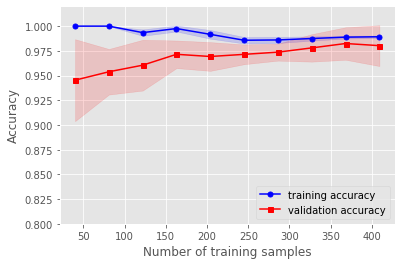

In [14]:
# 1.用学习曲线诊断偏差与方差
from sklearn.model_selection import learning_curve
pipe_lr3 = make_pipeline(StandardScaler(),LogisticRegression(random_state=1,penalty='l2'))
train_sizes,train_scores,test_scores = learning_curve(estimator=pipe_lr3,X=X_train,y=y_train,train_sizes=np.linspace(0.1,1,10),cv=10,n_jobs=1)
train_mean = np.mean(train_scores,axis=1)
train_std = np.std(train_scores,axis=1)
test_mean = np.mean(test_scores,axis=1)
test_std = np.std(test_scores,axis=1)
plt.plot(train_sizes,train_mean,color="blue",marker="o",markersize=5,label='training accuracy')
plt.fill_between(train_sizes,train_mean+train_std,train_mean-train_std,alpha=0.15,color='blue')
plt.plot(train_sizes,test_mean,color='red',marker='s',markersize=5,label='validation accuracy')
plt.fill_between(train_sizes,test_mean+test_std,test_mean-test_std,alpha=0.15,color='red')
plt.xlabel("Number of training samples")
plt.ylabel("Accuracy")
plt.legend(loc='lower right')
plt.ylim([0.8,1.02])
plt.show()

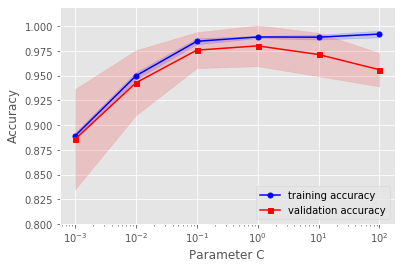

In [15]:
# 2.用验证曲线解决欠拟合和过拟合
from sklearn.model_selection import validation_curve
pipe_lr3 = make_pipeline(StandardScaler(),LogisticRegression(random_state=1,penalty='l2'))
param_range = [0.001,0.01,0.1,1.0,10.0,100.0]
train_scores,test_scores = validation_curve(estimator=pipe_lr3,X=X_train,y=y_train,param_name='logisticregression__C',param_range=param_range,cv=10,n_jobs=1)
train_mean = np.mean(train_scores,axis=1)
train_std = np.std(train_scores,axis=1)
test_mean = np.mean(test_scores,axis=1)
test_std = np.std(test_scores,axis=1)
plt.plot(param_range,train_mean,color='blue',marker='o',markersize=5,label='training accuracy')
plt.fill_between(param_range,train_mean+train_std,train_mean-train_std,alpha=0.15,color='blue')
plt.plot(param_range,test_mean,color='red',marker='s',markersize=5,label='validation accuracy')
plt.fill_between(param_range,test_mean+test_std,test_mean-test_std,alpha=0.15,color='red')
plt.xscale('log')
plt.xlabel("Parameter C")
plt.ylabel("Accuracy")
plt.legend(loc='lower right')
plt.ylim([0.8,1.02])
plt.show()

#### 通过网格搜索进行超参数调优

In [16]:
# 方式一：网格搜索GridSearchCV()
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import time
start_time = time.time()
pipe_svc = make_pipeline(StandardScaler(),SVC(random_state=1))
param_range = [0.0001,0.001,0.01,0.1,1.0,10.0,100.0,1000.0]
param_grid = [{'svc__C':param_range,'svc__kernel':['linear']},{'svc__C':param_range,'svc__gamma':param_range,'svc__kernel':['rbf']}]
gs = GridSearchCV(estimator=pipe_svc,param_grid=param_grid,scoring='accuracy',cv=10,n_jobs=-1)
gs = gs.fit(X_train,y_train)
end_time = time.time()
print("网格搜索经历时间：%.3f S" % float(end_time-start_time))
print(gs.best_score_)
print(gs.best_params_)

网格搜索经历时间：7.019 S
0.9846859903381642
{'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


In [18]:
# 方式二：随机网格搜索RandomizedSearchCV()
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
import time
start_time = time.time()
pipe_svc = make_pipeline(StandardScaler(),SVC(random_state=1))
param_range = [0.0001,0.001,0.01,0.1,1.0,10.0,100.0,1000.0]
param_grid = [{'svc__C':param_range,'svc__kernel':['linear']},{'svc__C':param_range,'svc__gamma':param_range,'svc__kernel':['rbf']}]
gs = RandomizedSearchCV(estimator=pipe_svc,param_distributions=param_grid,scoring='accuracy',cv=10,n_jobs=-1)
gs = gs.fit(X_train,y_train)
end_time = time.time()
print("随机网格搜索经历时间：%.3f S" % float(end_time-start_time))
print(gs.best_score_)
print(gs.best_params_)

随机网格搜索经历时间：3.372 S
0.9846859903381642
{'svc__kernel': 'rbf', 'svc__gamma': 0.001, 'svc__C': 100.0}


In [19]:
# 方式三：嵌套交叉验证
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
import time
start_time = time.time()
pipe_svc = make_pipeline(StandardScaler(),SVC(random_state=1))
param_grid = [{'svc__C':param_range,'svc__kernel':['linear']},{'svc__C':param_range,'svc__gamma':param_range,'svc__kernel':['rbf']}]
gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid,scoring='accuracy',cv=2,n_jobs=-1)
scores = cross_val_score(gs,X_train,y_train,scoring='accuracy',cv=5)
end_time = time.time()
print("嵌套交叉验证：%.3f S" % float(end_time-start_time))
print('CV accuracy :%.3f +/-%.3f'%(np.mean(scores),np.std(scores)))

嵌套交叉验证：3.951 S
CV accuracy :0.974 +/-0.015


#### 比较不同的性能评价指标

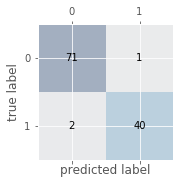

In [20]:
# 1.绘制混淆矩阵
from sklearn.metrics import confusion_matrix
pipe_svc.fit(X_train,y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true=y_test,y_pred=y_pred)
fig,ax = plt.subplots(figsize=(2.5,2.5))
ax.matshow(confmat,cmap=plt.cm.Blues,alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j,y=i,s=confmat[i,j],va='center',ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

In [22]:
confmat

array([[71,  1],
       [ 2, 40]], dtype=int64)

In [23]:
# 2.各种指标的计算
from sklearn.metrics import precision_score,recall_score,f1_score
print('Precision:%.3f'%precision_score(y_true=y_test,y_pred=y_pred))
print('recall_score:%.3f'%recall_score(y_true=y_test,y_pred=y_pred))
print('f1_score:%.3f'%f1_score(y_true=y_test,y_pred=y_pred))

Precision:0.976
recall_score:0.952
f1_score:0.964


In [24]:
# 3.将不同的指标与GridSearch结合
from sklearn.metrics import make_scorer,f1_score
scorer = make_scorer(f1_score,pos_label=0)
gs = GridSearchCV(estimator=pipe_svc,param_grid=param_grid,scoring=scorer,cv=10)
gs = gs.fit(X_train,y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9880771478667446
{'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


<Figure size 432x288 with 0 Axes>

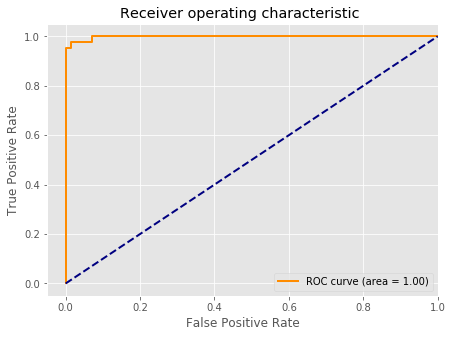

In [25]:
# 4.绘制ROC曲线
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import make_scorer,f1_score
scorer = make_scorer(f1_score,pos_label=0)
gs = GridSearchCV(estimator=pipe_svc,param_grid=param_grid,scoring=scorer,cv=10)
y_pred = gs.fit(X_train,y_train).decision_function(X_test)
#y_pred = gs.predict(X_test)
fpr,tpr,threshold = roc_curve(y_test, y_pred) ###计算真阳率和假阳率
roc_auc = auc(fpr,tpr) ###计算auc的值
plt.figure()
lw = 2
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假阳率为横坐标，真阳率为纵坐标做曲线
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic ')
plt.legend(loc="lower right")
plt.show()